In [479]:
#!pip install catboost
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool

import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

train_org = pd.read_csv('open/train.csv').drop(columns='ID')
test_org = pd.read_csv('open/test.csv').drop(columns='ID')

In [480]:
train_df = train_org.copy()
test_df = test_org.copy()

### ECLO(Equivalent Casualty Loss Only) : 인명피해 심각도  

- ECLO = 사망자수 * 10 + 중상자수 * 5 + 경상자수 * 3 + 부상자수 * 1  
- 본 대회에서는 사고의 위험도를 인명피해 심각도로 측정

- 음주운전  
- 트럭운전  
- 퇴근길, 출근길  
- 명절  
- 어린이 보호구역(에 주차한거)  
- 날씨(비, 눈)  
- 신호 위반  
- 오른쪽 커브길  
- 미성년자 운전  
- 졸음운전  
- 길가에 주차된 경우(불법주차)

In [481]:
light_df = pd.read_csv('open/external_open/대구 보안등 정보.csv', encoding='cp949')[['설치개수', '소재지지번주소']]

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소', '번지'])

light_df = light_df.groupby(['도시', '구', '동']).sum().reset_index()
light_df.reset_index(inplace=True, drop=True)

In [482]:
child_area_df = pd.read_csv('open/external_open/대구 어린이 보호 구역 정보.csv', encoding='cp949').drop_duplicates()[['소재지지번주소']]
child_area_df['cnt'] = 1

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지'])

child_area_df = child_area_df.groupby(['도시', '구', '동']).sum().reset_index()
child_area_df.reset_index(inplace=True, drop=True)

In [483]:
parking_df = pd.read_csv('open/external_open/대구 주차장 정보.csv', encoding='cp949')[['소재지지번주소', '급지구분']]
parking_df = pd.get_dummies(parking_df, columns=['급지구분'])

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지'])

parking_df = parking_df.groupby(['도시', '구', '동']).sum().reset_index()
parking_df.reset_index(inplace=True, drop=True)

In [435]:
# test_x = test_df.copy()
# train_x = train_df[test_x.columns].copy()
# train_y = train_df['ECLO'].copy()

# Data Preprocessing

In [436]:
train_df['총부상자수'] = train_df['사망자수']+train_df['중상자수']+train_df['부상자수']
grouped_mean = train_df.groupby('사고유형')['총부상자수'].mean().reset_index()
train_df = pd.merge(train_df, grouped_mean, on='사고유형', how='left', suffixes=('', '_평균'))

In [454]:
test_df = pd.merge(test_df, grouped_mean, on='사고유형', how='left', suffixes=('', '_평균'))

In [438]:
time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})' 

train_df[['연', '월', '일', '시간']] = train_org['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다 
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다 

# 해당 과정을 test_x에 대해서도 반복해줍니다 
test_df[['연', '월', '일', '시간']] = test_org['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

In [439]:
relative_frequency = train_df.groupby('시간')['총부상자수'].count() / train_df.groupby('시간')['총부상자수'].count().sum()
relative_frequency = relative_frequency.reset_index(name='시간별_총부상자수_비율')
train_df = pd.merge(train_df, relative_frequency, on='시간', how='left')
test_df = pd.merge(test_df, relative_frequency, on='시간', how='left')

In [440]:
X = train_df.drop(columns=['ECLO','부상자수','경상자수','중상자수','사망자수','피해운전자 상해정도','피해운전자 연령','피해운전자 차종','가해운전자 상해정도',
                           '가해운전자 연령','가해운전자 성별','가해운전자 차종','법규위반','사고유형 - 세부분류','피해운전자 성별'])
y = train_df['ECLO']

train_df = X

In [442]:
print(train_df.shape, y.shape,test_df.shape)

(39609, 13) (39609,) (10963, 12)


In [443]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

In [444]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

In [445]:
# train_df와 test_df에, light_df와 child_area_df, parking_df를 merge하세요.
train_df = pd.merge(train_df, light_df, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, child_area_df, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, parking_df, how='left', on=['도시', '구', '동'])

test_df = pd.merge(test_df, light_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, child_area_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, parking_df, how='left', on=['도시', '구', '동'])

In [456]:
train_df.columns

Index(['요일', '기상상태', '노면상태', '사고유형', '총부상자수', '총부상자수_평균', '연', '월', '일', '시간',
       '시간별_총부상자수_비율', '도시', '구', '동', '도로형태1', '도로형태2', '설치개수', 'cnt',
       '급지구분_1', '급지구분_2', '급지구분_3'],
      dtype='object')

In [455]:
test_df.columns

Index(['요일', '기상상태', '노면상태', '사고유형', '총부상자수', '연', '월', '일', '시간',
       '시간별_총부상자수_비율', '도시', '구', '동', '도로형태1', '도로형태2', '설치개수', 'cnt',
       '급지구분_1', '급지구분_2', '급지구분_3', '총부상자수_평균'],
      dtype='object')

In [380]:
# train_x= train_x.drop(columns= ['도시','연','월','일'])
# test_x= test_x.drop(columns= ['도시','연','월','일'])

----

train_cp = train.query('사고유형 == "차대사람"')
test_cp = test.query('사고유형 == "차대사람"')

train_cc = train.query('사고유형 == "차대차"')
test_cc = test.query('사고유형 == "차대차"')

train_c = train.query('사고유형 == "차량단독"')
test_c = test.query('사고유형 == "차량단독"')

y_cp = train_cp['ECLO']
y_cc = train_cc['ECLO']
y_c = train_c['ECLO']


train_cp = train_cp.drop(columns = 'ECLO')
train_cc = train_cc.drop(columns = 'ECLO')
train_c = train_c.drop(columns = 'ECLO')

# 모델 학습
model1 = CatBoostRegressor(iterations=200, depth=6, learning_rate=0.1)
model1.fit(train_cp,y_cp, verbose=1,cat_features=train_cp.columns.tolist())

model2 = CatBoostRegressor(iterations=200, depth=6, learning_rate=0.1)
model2.fit(train_cc,y_cc, verbose=1,cat_features=train_cp.columns.tolist())

model3 = CatBoostRegressor(iterations=200, depth=6, learning_rate=0.1)
model3.fit(train_c,y_c, verbose=1,cat_features=train_cp.columns.tolist())

test_cp["label"]= model1.predict(test_cp)

test_cc["label"]= model2.predict(test_cc)

test_c["label"]= model3.predict(test_c)

temp_test = pd.concat([test_cp,test_cc,test_c],axis= 0)
temp_test_sorted = temp_test.sort_index()

---

In [459]:
train_x = train_df
test_x = test_df

In [460]:
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
for feature in tqdm(categorical_features, desc="Encoding features"):
    encoder = LabelEncoder()
    train_x[feature] = encoder.fit_transform(train_x[feature])
    for label in np.unique(test_x[feature]):
        if label not in encoder.classes_:
            encoder.classes_ = np.append(encoder.classes_, label)
    test_x[feature] = encoder.transform(test_x[feature])

Encoding features: 100%|█████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 26.27it/s]


In [462]:
train_x.fillna(train_x.mean().round(),inplace= True)
test_x.fillna(test_x.mean().round(),inplace= True)

In [ ]:
train_x = train_x.drop(columns= ['총부상자수','도시','기상상태','연','노면상태'])
test_x = test_x.drop(columns= ['총부상자수','도시','기상상태','연','노면상태'])

In [474]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_x, y , test_size=0.2, random_state=42)

In [475]:
# 모델 학습
model = CatBoostRegressor(iterations=350, depth=5, learning_rate=0.01)
model.fit(X_train, y_train, verbose=1)

0:	learn: 3.2195013	total: 8.1ms	remaining: 2.83s
1:	learn: 3.2187475	total: 16.3ms	remaining: 2.84s
2:	learn: 3.2180534	total: 24.6ms	remaining: 2.85s
3:	learn: 3.2173615	total: 32.4ms	remaining: 2.8s
4:	learn: 3.2166695	total: 39.8ms	remaining: 2.75s
5:	learn: 3.2159362	total: 47.8ms	remaining: 2.74s
6:	learn: 3.2152443	total: 55.3ms	remaining: 2.71s
7:	learn: 3.2146882	total: 63.5ms	remaining: 2.71s
8:	learn: 3.2140428	total: 71ms	remaining: 2.69s
9:	learn: 3.2133828	total: 79ms	remaining: 2.69s
10:	learn: 3.2127133	total: 86.8ms	remaining: 2.67s
11:	learn: 3.2120904	total: 94.5ms	remaining: 2.66s
12:	learn: 3.2114640	total: 102ms	remaining: 2.65s
13:	learn: 3.2108552	total: 110ms	remaining: 2.65s
14:	learn: 3.2102829	total: 118ms	remaining: 2.64s
15:	learn: 3.2098024	total: 125ms	remaining: 2.62s
16:	learn: 3.2092123	total: 133ms	remaining: 2.61s
17:	learn: 3.2086357	total: 141ms	remaining: 2.61s
18:	learn: 3.2081244	total: 149ms	remaining: 2.6s
19:	learn: 3.2075982	total: 157ms	re

167:	learn: 3.1755598	total: 1.22s	remaining: 1.32s
168:	learn: 3.1754587	total: 1.22s	remaining: 1.31s
169:	learn: 3.1753827	total: 1.23s	remaining: 1.3s
170:	learn: 3.1752986	total: 1.24s	remaining: 1.29s
171:	learn: 3.1751850	total: 1.24s	remaining: 1.29s
172:	learn: 3.1751129	total: 1.25s	remaining: 1.28s
173:	learn: 3.1749615	total: 1.26s	remaining: 1.27s
174:	learn: 3.1748638	total: 1.27s	remaining: 1.27s
175:	learn: 3.1747874	total: 1.27s	remaining: 1.26s
176:	learn: 3.1746786	total: 1.28s	remaining: 1.25s
177:	learn: 3.1746073	total: 1.29s	remaining: 1.24s
178:	learn: 3.1745246	total: 1.29s	remaining: 1.24s
179:	learn: 3.1744698	total: 1.3s	remaining: 1.23s
180:	learn: 3.1743893	total: 1.31s	remaining: 1.22s
181:	learn: 3.1743170	total: 1.31s	remaining: 1.21s
182:	learn: 3.1742228	total: 1.32s	remaining: 1.21s
183:	learn: 3.1741411	total: 1.33s	remaining: 1.2s
184:	learn: 3.1740366	total: 1.34s	remaining: 1.19s
185:	learn: 3.1739696	total: 1.34s	remaining: 1.19s
186:	learn: 3.1

335:	learn: 3.1642036	total: 2.42s	remaining: 101ms
336:	learn: 3.1641524	total: 2.42s	remaining: 93.6ms
337:	learn: 3.1640903	total: 2.43s	remaining: 86.4ms
338:	learn: 3.1640392	total: 2.44s	remaining: 79.1ms
339:	learn: 3.1639969	total: 2.45s	remaining: 71.9ms
340:	learn: 3.1639098	total: 2.45s	remaining: 64.8ms
341:	learn: 3.1638672	total: 2.46s	remaining: 57.6ms
342:	learn: 3.1638174	total: 2.47s	remaining: 50.4ms
343:	learn: 3.1637280	total: 2.48s	remaining: 43.2ms
344:	learn: 3.1637009	total: 2.48s	remaining: 36ms
345:	learn: 3.1636203	total: 2.49s	remaining: 28.8ms
346:	learn: 3.1635595	total: 2.5s	remaining: 21.6ms
347:	learn: 3.1635188	total: 2.51s	remaining: 14.4ms
348:	learn: 3.1634322	total: 2.52s	remaining: 7.21ms
349:	learn: 3.1633645	total: 2.52s	remaining: 0us


In [476]:
# 모델 학습
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

In [477]:
from sklearn.metrics import mean_squared_log_error

rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_train_pred))
rmsle_val = np.sqrt(mean_squared_log_error(y_val, y_val_pred))

In [468]:
#년, 월 삭제
print('train rmsle :', rmsle_train)
print('val rmsle :', rmsle_val)

train rmsle : 0.43449209672675454
val rmsle : 0.43649846319081376


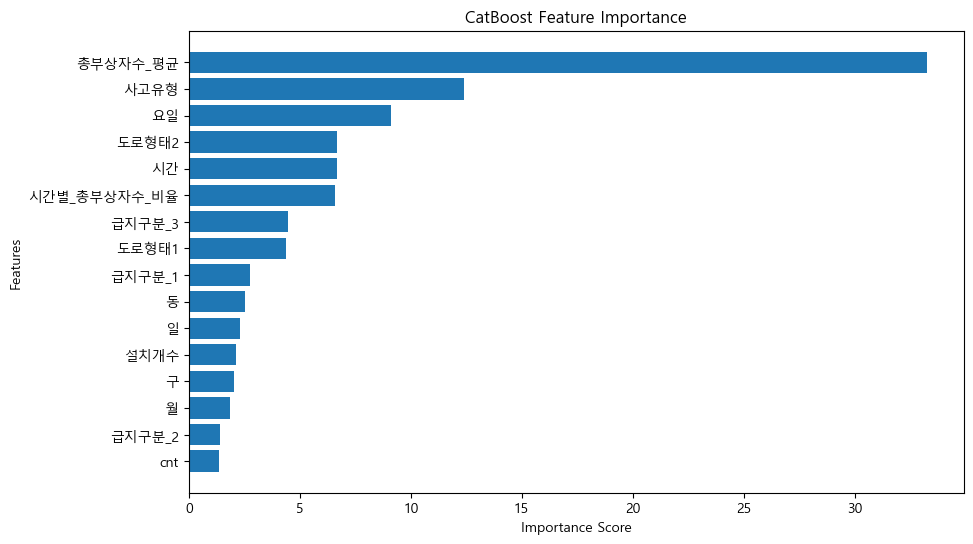

In [484]:
# Plot feature importance

import matplotlib.pyplot as plt

feature_importance = model.get_feature_importance(prettified=True)
feature_importance = feature_importance.sort_values(by='Importances', ascending=True)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature Id'], feature_importance['Importances'])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('CatBoost Feature Importance')
plt.show()

In [471]:
f_i = feature_importance.sort_values(by='Importances', ascending=False)

In [472]:
f_i

,Feature Id,Importances
0,총부상자수,70.276144
1,총부상자수_평균,10.852474
2,구,4.174401
3,급지구분_3,2.795891
4,사고유형,2.727152
5,요일,1.385346
6,시간,1.247529
7,시간별_총부상자수_비율,1.160678
8,도로형태2,0.946863
9,급지구분_1,0.810943


In [486]:
y_pred = model.predict(test_x)

In [494]:
y_pred = model.predict(test_x)

sample_submission = pd.read_csv('open/sample_submission.csv')
baseline_submission = sample_submission.copy()
baseline_submission['ECLO'] = y_pred
baseline_submission

,ID,ECLO
0,ACCIDENT_39609,4.257197
1,ACCIDENT_39610,4.025264
2,ACCIDENT_39611,5.777245
3,ACCIDENT_39612,5.408215
4,ACCIDENT_39613,5.326535
...,...,...
10958,ACCIDENT_50567,5.843446
10959,ACCIDENT_50568,4.869532
10960,ACCIDENT_50569,4.909609
10961,ACCIDENT_50570,5.018443


array([[<Axes: title={'center': 'ECLO'}>]], dtype=object)

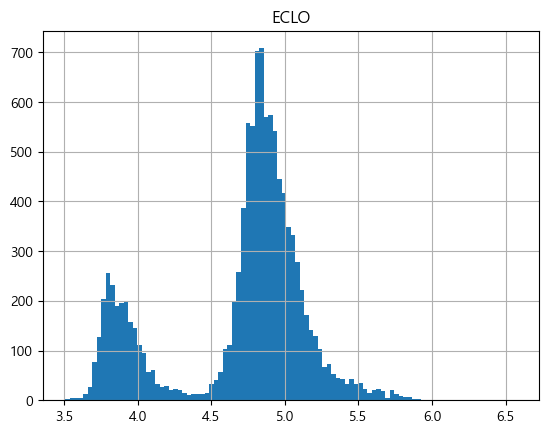

In [497]:
baseline_submission.hist(bins= 100)

In [498]:
baseline_submission.to_csv('base6_cat.csv', index=False)

---

In [84]:
from catboost import CatBoostRegressor
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# '시'별로 모델을 저장할 딕셔너리 생성
models_by_hour = {}

# 시간별로 데이터 분할 및 모델 학습
for hour in train['시'].unique():
    # 해당 시간의 데이터만 선택
    subset_data = train[train['시'] == str(hour)]
    
    # 훈련 데이터와 타겟 변수 분리
    X = subset_data.drop('ECLO', axis=1)
    y = subset_data['ECLO']

    # CatBoost 모델 초기화
    model = CatBoostRegressor(iterations=200, depth=6, learning_rate=0.01)
    model.fit(X, y, verbose=1, cat_features=X.columns.tolist())
    
    # 학습한 모델을 딕셔너리에 저장
    models_by_hour[hour] = model

0:	learn: 3.3674585	total: 7.02ms	remaining: 1.4s
1:	learn: 3.3661595	total: 28.3ms	remaining: 2.8s
2:	learn: 3.3633287	total: 53.9ms	remaining: 3.54s
3:	learn: 3.3617532	total: 68.1ms	remaining: 3.34s
4:	learn: 3.3599171	total: 91ms	remaining: 3.55s
5:	learn: 3.3585189	total: 111ms	remaining: 3.59s
6:	learn: 3.3574710	total: 118ms	remaining: 3.24s
7:	learn: 3.3562661	total: 132ms	remaining: 3.16s
8:	learn: 3.3546802	total: 151ms	remaining: 3.19s
9:	learn: 3.3521946	total: 170ms	remaining: 3.23s
10:	learn: 3.3504484	total: 190ms	remaining: 3.27s
11:	learn: 3.3484731	total: 211ms	remaining: 3.3s
12:	learn: 3.3469223	total: 233ms	remaining: 3.35s
13:	learn: 3.3449787	total: 254ms	remaining: 3.37s
14:	learn: 3.3430889	total: 275ms	remaining: 3.39s
15:	learn: 3.3421281	total: 288ms	remaining: 3.31s
16:	learn: 3.3405458	total: 309ms	remaining: 3.32s
17:	learn: 3.3391660	total: 329ms	remaining: 3.33s
18:	learn: 3.3389509	total: 351ms	remaining: 3.35s
19:	learn: 3.3376315	total: 372ms	remaini

171:	learn: 3.1979454	total: 3.3s	remaining: 537ms
172:	learn: 3.1966491	total: 3.32s	remaining: 518ms
173:	learn: 3.1962086	total: 3.34s	remaining: 499ms
174:	learn: 3.1954709	total: 3.36s	remaining: 480ms
175:	learn: 3.1948271	total: 3.38s	remaining: 461ms
176:	learn: 3.1946417	total: 3.4s	remaining: 441ms
177:	learn: 3.1941950	total: 3.42s	remaining: 422ms
178:	learn: 3.1940890	total: 3.43s	remaining: 403ms
179:	learn: 3.1935111	total: 3.45s	remaining: 384ms
180:	learn: 3.1933969	total: 3.46s	remaining: 363ms
181:	learn: 3.1927073	total: 3.48s	remaining: 344ms
182:	learn: 3.1916339	total: 3.5s	remaining: 325ms
183:	learn: 3.1911654	total: 3.52s	remaining: 306ms
184:	learn: 3.1904576	total: 3.54s	remaining: 287ms
185:	learn: 3.1897278	total: 3.56s	remaining: 268ms
186:	learn: 3.1890949	total: 3.59s	remaining: 249ms
187:	learn: 3.1889984	total: 3.6s	remaining: 230ms
188:	learn: 3.1880262	total: 3.62s	remaining: 211ms
189:	learn: 3.1875678	total: 3.65s	remaining: 192ms
190:	learn: 3.18

133:	learn: 3.4950007	total: 2.43s	remaining: 1.2s
134:	learn: 3.4941812	total: 2.45s	remaining: 1.18s
135:	learn: 3.4941583	total: 2.46s	remaining: 1.16s
136:	learn: 3.4934404	total: 2.48s	remaining: 1.14s
137:	learn: 3.4929135	total: 2.5s	remaining: 1.12s
138:	learn: 3.4909582	total: 2.52s	remaining: 1.1s
139:	learn: 3.4896303	total: 2.54s	remaining: 1.09s
140:	learn: 3.4887696	total: 2.56s	remaining: 1.07s
141:	learn: 3.4881761	total: 2.58s	remaining: 1.05s
142:	learn: 3.4881761	total: 2.59s	remaining: 1.03s
143:	learn: 3.4881379	total: 2.6s	remaining: 1.01s
144:	learn: 3.4878064	total: 2.61s	remaining: 992ms
145:	learn: 3.4865139	total: 2.63s	remaining: 975ms
146:	learn: 3.4859994	total: 2.66s	remaining: 958ms
147:	learn: 3.4858693	total: 2.68s	remaining: 941ms
148:	learn: 3.4849441	total: 2.7s	remaining: 924ms
149:	learn: 3.4838210	total: 2.72s	remaining: 907ms
150:	learn: 3.4831001	total: 2.76s	remaining: 896ms
151:	learn: 3.4828410	total: 2.77s	remaining: 874ms
152:	learn: 3.482

93:	learn: 3.6671044	total: 1.81s	remaining: 2.04s
94:	learn: 3.6647349	total: 1.83s	remaining: 2.02s
95:	learn: 3.6644391	total: 1.85s	remaining: 2s
96:	learn: 3.6642252	total: 1.86s	remaining: 1.97s
97:	learn: 3.6625936	total: 1.88s	remaining: 1.96s
98:	learn: 3.6617167	total: 1.9s	remaining: 1.94s
99:	learn: 3.6596428	total: 1.92s	remaining: 1.92s
100:	learn: 3.6589979	total: 1.93s	remaining: 1.89s
101:	learn: 3.6573852	total: 1.95s	remaining: 1.87s
102:	learn: 3.6553656	total: 1.97s	remaining: 1.85s
103:	learn: 3.6524723	total: 1.99s	remaining: 1.84s
104:	learn: 3.6506206	total: 2.01s	remaining: 1.82s
105:	learn: 3.6497771	total: 2.03s	remaining: 1.8s
106:	learn: 3.6480202	total: 2.05s	remaining: 1.78s
107:	learn: 3.6473206	total: 2.07s	remaining: 1.77s
108:	learn: 3.6473206	total: 2.08s	remaining: 1.74s
109:	learn: 3.6445473	total: 2.1s	remaining: 1.72s
110:	learn: 3.6445469	total: 2.11s	remaining: 1.69s
111:	learn: 3.6433620	total: 2.13s	remaining: 1.67s
112:	learn: 3.6429955	tot

56:	learn: 3.3560077	total: 1.08s	remaining: 2.71s
57:	learn: 3.3555853	total: 1.1s	remaining: 2.71s
58:	learn: 3.3550258	total: 1.12s	remaining: 2.67s
59:	learn: 3.3550076	total: 1.12s	remaining: 2.62s
60:	learn: 3.3549895	total: 1.13s	remaining: 2.58s
61:	learn: 3.3528484	total: 1.15s	remaining: 2.57s
62:	learn: 3.3510412	total: 1.17s	remaining: 2.55s
63:	learn: 3.3504457	total: 1.2s	remaining: 2.54s
64:	learn: 3.3494443	total: 1.22s	remaining: 2.52s
65:	learn: 3.3492098	total: 1.23s	remaining: 2.49s
66:	learn: 3.3475895	total: 1.25s	remaining: 2.48s
67:	learn: 3.3475718	total: 1.26s	remaining: 2.44s
68:	learn: 3.3454517	total: 1.28s	remaining: 2.43s
69:	learn: 3.3425049	total: 1.3s	remaining: 2.42s
70:	learn: 3.3417299	total: 1.32s	remaining: 2.41s
71:	learn: 3.3417122	total: 1.33s	remaining: 2.37s
72:	learn: 3.3404152	total: 1.35s	remaining: 2.35s
73:	learn: 3.3395512	total: 1.36s	remaining: 2.32s
74:	learn: 3.3379990	total: 1.38s	remaining: 2.3s
75:	learn: 3.3379818	total: 1.39s	r

28:	learn: 3.9048222	total: 442ms	remaining: 2.61s
29:	learn: 3.9043025	total: 464ms	remaining: 2.63s
30:	learn: 3.9041655	total: 474ms	remaining: 2.58s
31:	learn: 3.9021484	total: 493ms	remaining: 2.59s
32:	learn: 3.9021122	total: 503ms	remaining: 2.54s
33:	learn: 3.9018835	total: 515ms	remaining: 2.51s
34:	learn: 3.9011868	total: 533ms	remaining: 2.51s
35:	learn: 3.8983940	total: 552ms	remaining: 2.51s
36:	learn: 3.8977324	total: 576ms	remaining: 2.54s
37:	learn: 3.8973933	total: 597ms	remaining: 2.54s
38:	learn: 3.8973146	total: 618ms	remaining: 2.55s
39:	learn: 3.8972699	total: 628ms	remaining: 2.51s
40:	learn: 3.8972054	total: 637ms	remaining: 2.47s
41:	learn: 3.8955839	total: 660ms	remaining: 2.48s
42:	learn: 3.8941388	total: 683ms	remaining: 2.5s
43:	learn: 3.8940646	total: 697ms	remaining: 2.47s
44:	learn: 3.8937975	total: 715ms	remaining: 2.46s
45:	learn: 3.8907887	total: 734ms	remaining: 2.46s
46:	learn: 3.8890858	total: 754ms	remaining: 2.45s
47:	learn: 3.8889815	total: 764m

193:	learn: 3.7893707	total: 3.23s	remaining: 99.8ms
194:	learn: 3.7871836	total: 3.25s	remaining: 83.3ms
195:	learn: 3.7871466	total: 3.26s	remaining: 66.5ms
196:	learn: 3.7870588	total: 3.27s	remaining: 49.7ms
197:	learn: 3.7869439	total: 3.29s	remaining: 33.2ms
198:	learn: 3.7858327	total: 3.31s	remaining: 16.6ms
199:	learn: 3.7855365	total: 3.33s	remaining: 0us
0:	learn: 2.7701313	total: 11.6ms	remaining: 2.3s
1:	learn: 2.7689981	total: 33.1ms	remaining: 3.28s
2:	learn: 2.7674507	total: 54.1ms	remaining: 3.55s
3:	learn: 2.7664766	total: 76.3ms	remaining: 3.74s
4:	learn: 2.7659125	total: 98.4ms	remaining: 3.84s
5:	learn: 2.7648288	total: 120ms	remaining: 3.88s
6:	learn: 2.7641083	total: 143ms	remaining: 3.94s
7:	learn: 2.7636938	total: 166ms	remaining: 3.98s
8:	learn: 2.7628586	total: 187ms	remaining: 3.98s
9:	learn: 2.7626825	total: 208ms	remaining: 3.95s
10:	learn: 2.7624492	total: 231ms	remaining: 3.97s
11:	learn: 2.7621349	total: 254ms	remaining: 3.98s
12:	learn: 2.7619499	total

155:	learn: 2.6809840	total: 3.15s	remaining: 887ms
156:	learn: 2.6804813	total: 3.17s	remaining: 868ms
157:	learn: 2.6802660	total: 3.19s	remaining: 848ms
158:	learn: 2.6795578	total: 3.21s	remaining: 829ms
159:	learn: 2.6791013	total: 3.24s	remaining: 809ms
160:	learn: 2.6787661	total: 3.25s	remaining: 788ms
161:	learn: 2.6781687	total: 3.28s	remaining: 770ms
162:	learn: 2.6771423	total: 3.31s	remaining: 751ms
163:	learn: 2.6770127	total: 3.32s	remaining: 730ms
164:	learn: 2.6764197	total: 3.35s	remaining: 710ms
165:	learn: 2.6764118	total: 3.36s	remaining: 688ms
166:	learn: 2.6760236	total: 3.38s	remaining: 668ms
167:	learn: 2.6755397	total: 3.4s	remaining: 648ms
168:	learn: 2.6747739	total: 3.42s	remaining: 628ms
169:	learn: 2.6747585	total: 3.43s	remaining: 606ms
170:	learn: 2.6744399	total: 3.45s	remaining: 586ms
171:	learn: 2.6740885	total: 3.48s	remaining: 566ms
172:	learn: 2.6737377	total: 3.49s	remaining: 545ms
173:	learn: 2.6733209	total: 3.51s	remaining: 525ms
174:	learn: 2

119:	learn: 2.7776042	total: 2.47s	remaining: 1.65s
120:	learn: 2.7776032	total: 2.48s	remaining: 1.62s
121:	learn: 2.7775989	total: 2.49s	remaining: 1.59s
122:	learn: 2.7774061	total: 2.51s	remaining: 1.57s
123:	learn: 2.7767469	total: 2.53s	remaining: 1.55s
124:	learn: 2.7760591	total: 2.55s	remaining: 1.53s
125:	learn: 2.7755054	total: 2.57s	remaining: 1.51s
126:	learn: 2.7753735	total: 2.6s	remaining: 1.49s
127:	learn: 2.7749601	total: 2.62s	remaining: 1.47s
128:	learn: 2.7747733	total: 2.64s	remaining: 1.45s
129:	learn: 2.7745091	total: 2.65s	remaining: 1.43s
130:	learn: 2.7744274	total: 2.68s	remaining: 1.41s
131:	learn: 2.7743160	total: 2.7s	remaining: 1.39s
132:	learn: 2.7742101	total: 2.72s	remaining: 1.37s
133:	learn: 2.7737921	total: 2.74s	remaining: 1.35s
134:	learn: 2.7734469	total: 2.76s	remaining: 1.33s
135:	learn: 2.7734324	total: 2.77s	remaining: 1.3s
136:	learn: 2.7724312	total: 2.79s	remaining: 1.28s
137:	learn: 2.7723907	total: 2.81s	remaining: 1.26s
138:	learn: 2.7

82:	learn: 3.0617042	total: 1.62s	remaining: 2.28s
83:	learn: 3.0608279	total: 1.64s	remaining: 2.27s
84:	learn: 3.0599635	total: 1.66s	remaining: 2.25s
85:	learn: 3.0599314	total: 1.67s	remaining: 2.22s
86:	learn: 3.0597668	total: 1.69s	remaining: 2.2s
87:	learn: 3.0595667	total: 1.7s	remaining: 2.17s
88:	learn: 3.0595580	total: 1.71s	remaining: 2.13s
89:	learn: 3.0587934	total: 1.73s	remaining: 2.12s
90:	learn: 3.0584504	total: 1.75s	remaining: 2.1s
91:	learn: 3.0581476	total: 1.77s	remaining: 2.08s
92:	learn: 3.0572912	total: 1.8s	remaining: 2.07s
93:	learn: 3.0569847	total: 1.82s	remaining: 2.05s
94:	learn: 3.0568196	total: 1.84s	remaining: 2.04s
95:	learn: 3.0567482	total: 1.87s	remaining: 2.02s
96:	learn: 3.0567341	total: 1.88s	remaining: 2s
97:	learn: 3.0566499	total: 1.9s	remaining: 1.98s
98:	learn: 3.0566252	total: 1.91s	remaining: 1.95s
99:	learn: 3.0564714	total: 1.94s	remaining: 1.94s
100:	learn: 3.0561318	total: 1.96s	remaining: 1.92s
101:	learn: 3.0559058	total: 1.98s	rem

52:	learn: 3.2779056	total: 1.16s	remaining: 3.22s
53:	learn: 3.2778925	total: 1.17s	remaining: 3.17s
54:	learn: 3.2774073	total: 1.19s	remaining: 3.15s
55:	learn: 3.2767466	total: 1.22s	remaining: 3.13s
56:	learn: 3.2767329	total: 1.23s	remaining: 3.09s
57:	learn: 3.2760776	total: 1.25s	remaining: 3.07s
58:	learn: 3.2756544	total: 1.28s	remaining: 3.05s
59:	learn: 3.2751248	total: 1.3s	remaining: 3.03s
60:	learn: 3.2751116	total: 1.31s	remaining: 2.99s
61:	learn: 3.2742291	total: 1.33s	remaining: 2.97s
62:	learn: 3.2741778	total: 1.36s	remaining: 2.96s
63:	learn: 3.2739440	total: 1.38s	remaining: 2.94s
64:	learn: 3.2736425	total: 1.4s	remaining: 2.92s
65:	learn: 3.2732986	total: 1.43s	remaining: 2.89s
66:	learn: 3.2727453	total: 1.45s	remaining: 2.88s
67:	learn: 3.2724571	total: 1.47s	remaining: 2.85s
68:	learn: 3.2720241	total: 1.49s	remaining: 2.83s
69:	learn: 3.2715041	total: 1.52s	remaining: 2.82s
70:	learn: 3.2695650	total: 1.54s	remaining: 2.79s
71:	learn: 3.2681028	total: 1.56s

21:	learn: 3.1860819	total: 439ms	remaining: 3.56s
22:	learn: 3.1856808	total: 450ms	remaining: 3.47s
23:	learn: 3.1851285	total: 480ms	remaining: 3.52s
24:	learn: 3.1844818	total: 506ms	remaining: 3.54s
25:	learn: 3.1841237	total: 531ms	remaining: 3.55s
26:	learn: 3.1837323	total: 558ms	remaining: 3.58s
27:	learn: 3.1831262	total: 584ms	remaining: 3.59s
28:	learn: 3.1825671	total: 625ms	remaining: 3.69s
29:	learn: 3.1820902	total: 652ms	remaining: 3.7s
30:	learn: 3.1817002	total: 684ms	remaining: 3.73s
31:	learn: 3.1812504	total: 717ms	remaining: 3.76s
32:	learn: 3.1806272	total: 745ms	remaining: 3.77s
33:	learn: 3.1802700	total: 756ms	remaining: 3.69s
34:	learn: 3.1799462	total: 765ms	remaining: 3.61s
35:	learn: 3.1796144	total: 780ms	remaining: 3.55s
36:	learn: 3.1792896	total: 808ms	remaining: 3.56s
37:	learn: 3.1787244	total: 834ms	remaining: 3.55s
38:	learn: 3.1783371	total: 861ms	remaining: 3.55s
39:	learn: 3.1776861	total: 885ms	remaining: 3.54s
40:	learn: 3.1773154	total: 909m

188:	learn: 3.1364264	total: 4.34s	remaining: 253ms
189:	learn: 3.1362976	total: 4.38s	remaining: 230ms
190:	learn: 3.1360335	total: 4.4s	remaining: 208ms
191:	learn: 3.1358254	total: 4.43s	remaining: 185ms
192:	learn: 3.1355029	total: 4.46s	remaining: 162ms
193:	learn: 3.1353043	total: 4.49s	remaining: 139ms
194:	learn: 3.1352214	total: 4.52s	remaining: 116ms
195:	learn: 3.1350474	total: 4.53s	remaining: 92.5ms
196:	learn: 3.1346130	total: 4.56s	remaining: 69.4ms
197:	learn: 3.1344023	total: 4.59s	remaining: 46.3ms
198:	learn: 3.1341600	total: 4.64s	remaining: 23.3ms
199:	learn: 3.1341428	total: 4.65s	remaining: 0us
0:	learn: 3.0969190	total: 5.82ms	remaining: 1.16s
1:	learn: 3.0964675	total: 15ms	remaining: 1.48s
2:	learn: 3.0959292	total: 41.9ms	remaining: 2.75s
3:	learn: 3.0953209	total: 72.6ms	remaining: 3.56s
4:	learn: 3.0946777	total: 106ms	remaining: 4.12s
5:	learn: 3.0942602	total: 117ms	remaining: 3.77s
6:	learn: 3.0936871	total: 149ms	remaining: 4.11s
7:	learn: 3.0931835	tot

158:	learn: 3.0490594	total: 3.57s	remaining: 921ms
159:	learn: 3.0490272	total: 3.58s	remaining: 896ms
160:	learn: 3.0489162	total: 3.6s	remaining: 873ms
161:	learn: 3.0486494	total: 3.63s	remaining: 851ms
162:	learn: 3.0483299	total: 3.65s	remaining: 828ms
163:	learn: 3.0482672	total: 3.66s	remaining: 804ms
164:	learn: 3.0479951	total: 3.68s	remaining: 782ms
165:	learn: 3.0479227	total: 3.7s	remaining: 757ms
166:	learn: 3.0475853	total: 3.72s	remaining: 735ms
167:	learn: 3.0471636	total: 3.74s	remaining: 713ms
168:	learn: 3.0466609	total: 3.77s	remaining: 691ms
169:	learn: 3.0466608	total: 3.78s	remaining: 667ms
170:	learn: 3.0464924	total: 3.8s	remaining: 645ms
171:	learn: 3.0463289	total: 3.82s	remaining: 623ms
172:	learn: 3.0462382	total: 3.85s	remaining: 600ms
173:	learn: 3.0462315	total: 3.86s	remaining: 577ms
174:	learn: 3.0460002	total: 3.88s	remaining: 555ms
175:	learn: 3.0460002	total: 3.89s	remaining: 531ms
176:	learn: 3.0458722	total: 3.91s	remaining: 509ms
177:	learn: 3.0

128:	learn: 3.0508547	total: 2.81s	remaining: 1.54s
129:	learn: 3.0504710	total: 2.83s	remaining: 1.53s
130:	learn: 3.0499356	total: 2.86s	remaining: 1.5s
131:	learn: 3.0497689	total: 2.89s	remaining: 1.49s
132:	learn: 3.0492757	total: 2.92s	remaining: 1.47s
133:	learn: 3.0490012	total: 2.95s	remaining: 1.45s
134:	learn: 3.0488366	total: 2.97s	remaining: 1.43s
135:	learn: 3.0486716	total: 3.01s	remaining: 1.42s
136:	learn: 3.0484770	total: 3.04s	remaining: 1.4s
137:	learn: 3.0482319	total: 3.06s	remaining: 1.38s
138:	learn: 3.0482199	total: 3.08s	remaining: 1.35s
139:	learn: 3.0480558	total: 3.1s	remaining: 1.33s
140:	learn: 3.0474733	total: 3.13s	remaining: 1.31s
141:	learn: 3.0470654	total: 3.16s	remaining: 1.29s
142:	learn: 3.0469247	total: 3.19s	remaining: 1.27s
143:	learn: 3.0465474	total: 3.21s	remaining: 1.25s
144:	learn: 3.0463070	total: 3.24s	remaining: 1.23s
145:	learn: 3.0462489	total: 3.25s	remaining: 1.2s
146:	learn: 3.0459096	total: 3.27s	remaining: 1.18s
147:	learn: 3.04

95:	learn: 3.3854818	total: 1.79s	remaining: 1.94s
96:	learn: 3.3848754	total: 1.81s	remaining: 1.92s
97:	learn: 3.3845159	total: 1.83s	remaining: 1.9s
98:	learn: 3.3837824	total: 1.86s	remaining: 1.9s
99:	learn: 3.3837823	total: 1.86s	remaining: 1.86s
100:	learn: 3.3831563	total: 1.88s	remaining: 1.85s
101:	learn: 3.3831054	total: 1.89s	remaining: 1.82s
102:	learn: 3.3823816	total: 1.91s	remaining: 1.8s
103:	learn: 3.3818379	total: 1.93s	remaining: 1.78s
104:	learn: 3.3810375	total: 1.95s	remaining: 1.77s
105:	learn: 3.3810282	total: 1.97s	remaining: 1.74s
106:	learn: 3.3806255	total: 1.99s	remaining: 1.73s
107:	learn: 3.3800926	total: 2.01s	remaining: 1.72s
108:	learn: 3.3799403	total: 2.04s	remaining: 1.7s
109:	learn: 3.3793627	total: 2.06s	remaining: 1.68s
110:	learn: 3.3785544	total: 2.09s	remaining: 1.67s
111:	learn: 3.3778137	total: 2.12s	remaining: 1.66s
112:	learn: 3.3778134	total: 2.12s	remaining: 1.63s
113:	learn: 3.3776475	total: 2.15s	remaining: 1.62s
114:	learn: 3.3775565

59:	learn: 2.8980604	total: 1.45s	remaining: 3.38s
60:	learn: 2.8971841	total: 1.47s	remaining: 3.35s
61:	learn: 2.8967517	total: 1.49s	remaining: 3.31s
62:	learn: 2.8964471	total: 1.5s	remaining: 3.26s
63:	learn: 2.8960886	total: 1.52s	remaining: 3.23s
64:	learn: 2.8959910	total: 1.54s	remaining: 3.2s
65:	learn: 2.8952310	total: 1.56s	remaining: 3.17s
66:	learn: 2.8951663	total: 1.57s	remaining: 3.12s
67:	learn: 2.8944245	total: 1.59s	remaining: 3.09s
68:	learn: 2.8937932	total: 1.61s	remaining: 3.06s
69:	learn: 2.8934180	total: 1.63s	remaining: 3.03s
70:	learn: 2.8931075	total: 1.67s	remaining: 3.04s
71:	learn: 2.8923020	total: 1.69s	remaining: 3.01s
72:	learn: 2.8917894	total: 1.72s	remaining: 2.98s
73:	learn: 2.8915197	total: 1.74s	remaining: 2.96s
74:	learn: 2.8914480	total: 1.75s	remaining: 2.92s
75:	learn: 2.8911052	total: 1.77s	remaining: 2.9s
76:	learn: 2.8905210	total: 1.8s	remaining: 2.87s
77:	learn: 2.8902123	total: 1.82s	remaining: 2.85s
78:	learn: 2.8897395	total: 1.84s	r

20:	learn: 2.9736167	total: 442ms	remaining: 3.76s
21:	learn: 2.9731187	total: 466ms	remaining: 3.77s
22:	learn: 2.9725678	total: 488ms	remaining: 3.75s
23:	learn: 2.9725606	total: 498ms	remaining: 3.65s
24:	learn: 2.9719291	total: 522ms	remaining: 3.65s
25:	learn: 2.9715719	total: 545ms	remaining: 3.64s
26:	learn: 2.9711855	total: 567ms	remaining: 3.63s
27:	learn: 2.9705654	total: 589ms	remaining: 3.62s
28:	learn: 2.9701227	total: 612ms	remaining: 3.61s
29:	learn: 2.9695416	total: 634ms	remaining: 3.59s
30:	learn: 2.9688102	total: 656ms	remaining: 3.58s
31:	learn: 2.9679121	total: 682ms	remaining: 3.58s
32:	learn: 2.9674571	total: 705ms	remaining: 3.57s
33:	learn: 2.9670559	total: 726ms	remaining: 3.54s
34:	learn: 2.9666096	total: 753ms	remaining: 3.55s
35:	learn: 2.9659078	total: 779ms	remaining: 3.55s
36:	learn: 2.9659031	total: 787ms	remaining: 3.46s
37:	learn: 2.9655202	total: 816ms	remaining: 3.48s
38:	learn: 2.9650572	total: 846ms	remaining: 3.49s
39:	learn: 2.9648708	total: 856

184:	learn: 2.9109803	total: 4.22s	remaining: 342ms
185:	learn: 2.9109663	total: 4.23s	remaining: 318ms
186:	learn: 2.9105592	total: 4.25s	remaining: 296ms
187:	learn: 2.9102367	total: 4.28s	remaining: 273ms
188:	learn: 2.9098542	total: 4.3s	remaining: 250ms
189:	learn: 2.9097037	total: 4.33s	remaining: 228ms
190:	learn: 2.9096025	total: 4.36s	remaining: 206ms
191:	learn: 2.9095052	total: 4.38s	remaining: 182ms
192:	learn: 2.9090424	total: 4.4s	remaining: 160ms
193:	learn: 2.9086265	total: 4.43s	remaining: 137ms
194:	learn: 2.9083483	total: 4.46s	remaining: 114ms
195:	learn: 2.9082364	total: 4.48s	remaining: 91.5ms
196:	learn: 2.9079623	total: 4.51s	remaining: 68.7ms
197:	learn: 2.9079547	total: 4.52s	remaining: 45.7ms
198:	learn: 2.9077647	total: 4.54s	remaining: 22.8ms
199:	learn: 2.9076040	total: 4.57s	remaining: 0us
0:	learn: 3.1118939	total: 22.7ms	remaining: 4.52s
1:	learn: 3.1110118	total: 47.8ms	remaining: 4.73s
2:	learn: 3.1101371	total: 73.2ms	remaining: 4.81s
3:	learn: 3.109

154:	learn: 3.0480676	total: 3.55s	remaining: 1.03s
155:	learn: 3.0480676	total: 3.56s	remaining: 1s
156:	learn: 3.0480572	total: 3.59s	remaining: 983ms
157:	learn: 3.0479168	total: 3.61s	remaining: 960ms
158:	learn: 3.0474158	total: 3.63s	remaining: 937ms
159:	learn: 3.0471392	total: 3.66s	remaining: 915ms
160:	learn: 3.0466635	total: 3.68s	remaining: 892ms
161:	learn: 3.0465792	total: 3.71s	remaining: 870ms
162:	learn: 3.0462603	total: 3.73s	remaining: 847ms
163:	learn: 3.0459672	total: 3.76s	remaining: 825ms
164:	learn: 3.0458313	total: 3.78s	remaining: 802ms
165:	learn: 3.0457287	total: 3.8s	remaining: 778ms
166:	learn: 3.0451210	total: 3.82s	remaining: 755ms
167:	learn: 3.0447879	total: 3.84s	remaining: 732ms
168:	learn: 3.0442442	total: 3.87s	remaining: 709ms
169:	learn: 3.0439809	total: 3.88s	remaining: 686ms
170:	learn: 3.0437843	total: 3.91s	remaining: 663ms
171:	learn: 3.0436944	total: 3.92s	remaining: 638ms
172:	learn: 3.0435593	total: 3.94s	remaining: 615ms
173:	learn: 3.04

118:	learn: 3.3658360	total: 2.97s	remaining: 2.02s
119:	learn: 3.3657907	total: 2.99s	remaining: 1.99s
120:	learn: 3.3656371	total: 3.02s	remaining: 1.97s
121:	learn: 3.3655102	total: 3.03s	remaining: 1.94s
122:	learn: 3.3646141	total: 3.06s	remaining: 1.91s
123:	learn: 3.3639292	total: 3.08s	remaining: 1.89s
124:	learn: 3.3632565	total: 3.11s	remaining: 1.86s
125:	learn: 3.3629770	total: 3.13s	remaining: 1.84s
126:	learn: 3.3620044	total: 3.15s	remaining: 1.81s
127:	learn: 3.3618795	total: 3.17s	remaining: 1.78s
128:	learn: 3.3614258	total: 3.21s	remaining: 1.76s
129:	learn: 3.3612970	total: 3.23s	remaining: 1.74s
130:	learn: 3.3610199	total: 3.26s	remaining: 1.72s
131:	learn: 3.3605019	total: 3.29s	remaining: 1.69s
132:	learn: 3.3600395	total: 3.32s	remaining: 1.67s
133:	learn: 3.3599860	total: 3.34s	remaining: 1.65s
134:	learn: 3.3599579	total: 3.36s	remaining: 1.62s
135:	learn: 3.3593967	total: 3.39s	remaining: 1.59s
136:	learn: 3.3587211	total: 3.42s	remaining: 1.57s
137:	learn: 

80:	learn: 3.0853694	total: 1.75s	remaining: 2.56s
81:	learn: 3.0850847	total: 1.77s	remaining: 2.55s
82:	learn: 3.0847293	total: 1.79s	remaining: 2.53s
83:	learn: 3.0838799	total: 1.81s	remaining: 2.51s
84:	learn: 3.0833470	total: 1.84s	remaining: 2.49s
85:	learn: 3.0826764	total: 1.86s	remaining: 2.47s
86:	learn: 3.0824638	total: 1.87s	remaining: 2.43s
87:	learn: 3.0817992	total: 1.89s	remaining: 2.41s
88:	learn: 3.0814319	total: 1.92s	remaining: 2.39s
89:	learn: 3.0808302	total: 1.94s	remaining: 2.38s
90:	learn: 3.0801512	total: 1.97s	remaining: 2.36s
91:	learn: 3.0799538	total: 1.98s	remaining: 2.32s
92:	learn: 3.0798402	total: 2s	remaining: 2.3s
93:	learn: 3.0795102	total: 2.02s	remaining: 2.28s
94:	learn: 3.0794975	total: 2.03s	remaining: 2.25s
95:	learn: 3.0790160	total: 2.06s	remaining: 2.23s
96:	learn: 3.0788949	total: 2.06s	remaining: 2.19s
97:	learn: 3.0786567	total: 2.09s	remaining: 2.18s
98:	learn: 3.0781486	total: 2.11s	remaining: 2.16s
99:	learn: 3.0777858	total: 2.14s	r

47:	learn: 3.2217171	total: 1.02s	remaining: 3.22s
48:	learn: 3.2213658	total: 1.04s	remaining: 3.21s
49:	learn: 3.2210310	total: 1.07s	remaining: 3.2s
50:	learn: 3.2207047	total: 1.09s	remaining: 3.19s
51:	learn: 3.2202720	total: 1.11s	remaining: 3.17s
52:	learn: 3.2198169	total: 1.14s	remaining: 3.16s
53:	learn: 3.2194679	total: 1.16s	remaining: 3.14s
54:	learn: 3.2191093	total: 1.18s	remaining: 3.1s
55:	learn: 3.2188122	total: 1.18s	remaining: 3.04s
56:	learn: 3.2187169	total: 1.21s	remaining: 3.03s
57:	learn: 3.2184256	total: 1.21s	remaining: 2.97s
58:	learn: 3.2178858	total: 1.24s	remaining: 2.96s
59:	learn: 3.2175779	total: 1.25s	remaining: 2.93s
60:	learn: 3.2168580	total: 1.28s	remaining: 2.91s
61:	learn: 3.2163326	total: 1.3s	remaining: 2.89s
62:	learn: 3.2161852	total: 1.31s	remaining: 2.84s
63:	learn: 3.2158098	total: 1.33s	remaining: 2.82s
64:	learn: 3.2157353	total: 1.34s	remaining: 2.78s
65:	learn: 3.2154455	total: 1.36s	remaining: 2.75s
66:	learn: 3.2151856	total: 1.37s	

14:	learn: 3.1058175	total: 285ms	remaining: 3.52s
15:	learn: 3.1041922	total: 316ms	remaining: 3.63s
16:	learn: 3.1025131	total: 338ms	remaining: 3.64s
17:	learn: 3.1007934	total: 362ms	remaining: 3.66s
18:	learn: 3.0989922	total: 385ms	remaining: 3.67s
19:	learn: 3.0973970	total: 407ms	remaining: 3.67s
20:	learn: 3.0962696	total: 425ms	remaining: 3.62s
21:	learn: 3.0947573	total: 446ms	remaining: 3.61s
22:	learn: 3.0934830	total: 476ms	remaining: 3.66s
23:	learn: 3.0919666	total: 500ms	remaining: 3.66s
24:	learn: 3.0907551	total: 524ms	remaining: 3.67s
25:	learn: 3.0893565	total: 548ms	remaining: 3.67s
26:	learn: 3.0882746	total: 571ms	remaining: 3.66s
27:	learn: 3.0873470	total: 578ms	remaining: 3.55s
28:	learn: 3.0863552	total: 594ms	remaining: 3.5s
29:	learn: 3.0850891	total: 617ms	remaining: 3.5s
30:	learn: 3.0839510	total: 639ms	remaining: 3.48s
31:	learn: 3.0826790	total: 661ms	remaining: 3.47s
32:	learn: 3.0817695	total: 684ms	remaining: 3.46s
33:	learn: 3.0807523	total: 708ms

182:	learn: 2.9695102	total: 4.03s	remaining: 374ms
183:	learn: 2.9694464	total: 4.05s	remaining: 352ms
184:	learn: 2.9691751	total: 4.08s	remaining: 331ms
185:	learn: 2.9686811	total: 4.1s	remaining: 309ms
186:	learn: 2.9683005	total: 4.13s	remaining: 287ms
187:	learn: 2.9679381	total: 4.15s	remaining: 265ms
188:	learn: 2.9675836	total: 4.17s	remaining: 243ms
189:	learn: 2.9662142	total: 4.2s	remaining: 221ms
190:	learn: 2.9653131	total: 4.23s	remaining: 199ms
191:	learn: 2.9640155	total: 4.25s	remaining: 177ms
192:	learn: 2.9636220	total: 4.28s	remaining: 155ms
193:	learn: 2.9626962	total: 4.3s	remaining: 133ms
194:	learn: 2.9622821	total: 4.31s	remaining: 111ms
195:	learn: 2.9612979	total: 4.34s	remaining: 88.5ms
196:	learn: 2.9605386	total: 4.36s	remaining: 66.4ms
197:	learn: 2.9601281	total: 4.39s	remaining: 44.3ms
198:	learn: 2.9597694	total: 4.42s	remaining: 22.2ms
199:	learn: 2.9592179	total: 4.46s	remaining: 0us
0:	learn: 3.7671294	total: 20.7ms	remaining: 4.11s
1:	learn: 3.76

152:	learn: 3.4448331	total: 3.01s	remaining: 925ms
153:	learn: 3.4445256	total: 3.02s	remaining: 903ms
154:	learn: 3.4441161	total: 3.04s	remaining: 883ms
155:	learn: 3.4433275	total: 3.05s	remaining: 860ms
156:	learn: 3.4425364	total: 3.07s	remaining: 841ms
157:	learn: 3.4402892	total: 3.09s	remaining: 822ms
158:	learn: 3.4370806	total: 3.12s	remaining: 803ms
159:	learn: 3.4370465	total: 3.12s	remaining: 781ms
160:	learn: 3.4350142	total: 3.14s	remaining: 761ms
161:	learn: 3.4334290	total: 3.16s	remaining: 742ms
162:	learn: 3.4329899	total: 3.19s	remaining: 724ms
163:	learn: 3.4314305	total: 3.21s	remaining: 705ms
164:	learn: 3.4279243	total: 3.24s	remaining: 686ms
165:	learn: 3.4265529	total: 3.26s	remaining: 668ms
166:	learn: 3.4244812	total: 3.28s	remaining: 648ms
167:	learn: 3.4231812	total: 3.3s	remaining: 628ms
168:	learn: 3.4222983	total: 3.32s	remaining: 609ms
169:	learn: 3.4200176	total: 3.34s	remaining: 590ms
170:	learn: 3.4194831	total: 3.37s	remaining: 571ms
171:	learn: 3

116:	learn: 3.0503080	total: 2.7s	remaining: 1.91s
117:	learn: 3.0502140	total: 2.71s	remaining: 1.88s
118:	learn: 3.0499061	total: 2.73s	remaining: 1.86s
119:	learn: 3.0495849	total: 2.75s	remaining: 1.84s
120:	learn: 3.0495787	total: 2.76s	remaining: 1.8s
121:	learn: 3.0490994	total: 2.79s	remaining: 1.78s
122:	learn: 3.0487756	total: 2.81s	remaining: 1.76s
123:	learn: 3.0483187	total: 2.83s	remaining: 1.74s
124:	learn: 3.0480832	total: 2.85s	remaining: 1.71s
125:	learn: 3.0474333	total: 2.88s	remaining: 1.69s
126:	learn: 3.0473388	total: 2.9s	remaining: 1.67s
127:	learn: 3.0470092	total: 2.94s	remaining: 1.65s
128:	learn: 3.0460847	total: 2.96s	remaining: 1.63s
129:	learn: 3.0458009	total: 2.98s	remaining: 1.6s
130:	learn: 3.0452886	total: 3.01s	remaining: 1.58s
131:	learn: 3.0450724	total: 3.03s	remaining: 1.56s
132:	learn: 3.0446496	total: 3.05s	remaining: 1.54s
133:	learn: 3.0444584	total: 3.08s	remaining: 1.51s
134:	learn: 3.0439978	total: 3.1s	remaining: 1.49s
135:	learn: 3.043

85:	learn: 2.9575994	total: 1.79s	remaining: 2.37s
86:	learn: 2.9572744	total: 1.81s	remaining: 2.35s
87:	learn: 2.9568561	total: 1.83s	remaining: 2.33s
88:	learn: 2.9567696	total: 1.85s	remaining: 2.31s
89:	learn: 2.9560874	total: 1.87s	remaining: 2.29s
90:	learn: 2.9558831	total: 1.9s	remaining: 2.27s
91:	learn: 2.9555158	total: 1.92s	remaining: 2.25s
92:	learn: 2.9547883	total: 1.94s	remaining: 2.24s
93:	learn: 2.9544952	total: 1.97s	remaining: 2.22s
94:	learn: 2.9541428	total: 1.99s	remaining: 2.2s
95:	learn: 2.9535525	total: 2.02s	remaining: 2.18s
96:	learn: 2.9534951	total: 2.04s	remaining: 2.17s
97:	learn: 2.9531186	total: 2.06s	remaining: 2.15s
98:	learn: 2.9526895	total: 2.08s	remaining: 2.13s
99:	learn: 2.9525163	total: 2.11s	remaining: 2.11s
100:	learn: 2.9521261	total: 2.13s	remaining: 2.09s
101:	learn: 2.9517760	total: 2.15s	remaining: 2.07s
102:	learn: 2.9516313	total: 2.16s	remaining: 2.04s
103:	learn: 2.9511805	total: 2.18s	remaining: 2.02s
104:	learn: 2.9507885	total: 

51:	learn: 3.3837861	total: 1.14s	remaining: 3.24s
52:	learn: 3.3834372	total: 1.16s	remaining: 3.22s
53:	learn: 3.3826333	total: 1.18s	remaining: 3.2s
54:	learn: 3.3820318	total: 1.21s	remaining: 3.19s
55:	learn: 3.3812704	total: 1.23s	remaining: 3.17s
56:	learn: 3.3808017	total: 1.25s	remaining: 3.15s
57:	learn: 3.3804478	total: 1.28s	remaining: 3.13s
58:	learn: 3.3787424	total: 1.3s	remaining: 3.11s
59:	learn: 3.3780574	total: 1.32s	remaining: 3.09s
60:	learn: 3.3774798	total: 1.35s	remaining: 3.07s
61:	learn: 3.3771155	total: 1.37s	remaining: 3.05s
62:	learn: 3.3763698	total: 1.41s	remaining: 3.08s
63:	learn: 3.3749095	total: 1.44s	remaining: 3.05s
64:	learn: 3.3744177	total: 1.46s	remaining: 3.03s
65:	learn: 3.3743500	total: 1.47s	remaining: 2.99s
66:	learn: 3.3739036	total: 1.49s	remaining: 2.97s
67:	learn: 3.3735851	total: 1.53s	remaining: 2.97s
68:	learn: 3.3730435	total: 1.55s	remaining: 2.95s
69:	learn: 3.3728938	total: 1.56s	remaining: 2.9s
70:	learn: 3.3726566	total: 1.59s	

In [122]:
# 시간별로 모델을 활용한 예측 수행
predictions_by_hour = {}
for hour, model in models_by_hour.items():
    # 해당 시간의 테스트 데이터 선택
    test_data = test[test['시'] == int(hour)]
    
    # 예측 수행
    predictions = model.predict(test_data)
    
    # 결과를 딕셔너리에 저장
    test.loc[test['시'] == int(hour), 'predictions'] = predictions

In [117]:
# 예측 결과를 하나의 배열로 결합
final_predictions = []
for hour in test['시']:
    final_predictions.append(predictions_by_hour[hour])

In [493]:
# 최종 예측 결과를 평가
#final_predictions = np.concatenate(final_predictions)

# submission 파일 생성
sample_submission = pd.read_csv('open/sample_submission.csv')
baseline_submission = sample_submission.copy()
baseline_submission['ECLO'] = test['predictions']
baseline_submission

NameError: name 'test' is not defined

In [125]:
baseline_submission.to_csv('base4.csv', index=False)